In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

Code from: 

https://medium.com/@thiscuriousquest/using-python-to-understand-why-you-always-lose-your-fantasy-league-82c5db80f5b8


Written by Michael Wayne Smith

In [2]:
yrs = range(2018, 2023)
play_by = nfl.import_pbp_data(yrs)

2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [3]:
#Find running plays only
q = 'play_type == "run" & rusher_id.notnull()'

play_by_run = play_by.query(q).reset_index()
play_by_run.loc[play_by_run.rushing_yards.isnull(), 'rushing yards'] = 0

In [4]:
play_by_run_avg = (play_by_run.groupby(['ydstogo'])
                               .agg({'rushing_yards': ['mean']}))

play_by_run_avg.columns = list(map('_'.join, play_by_run_avg.columns))
play_by_run_avg.reset_index(inplace=True)

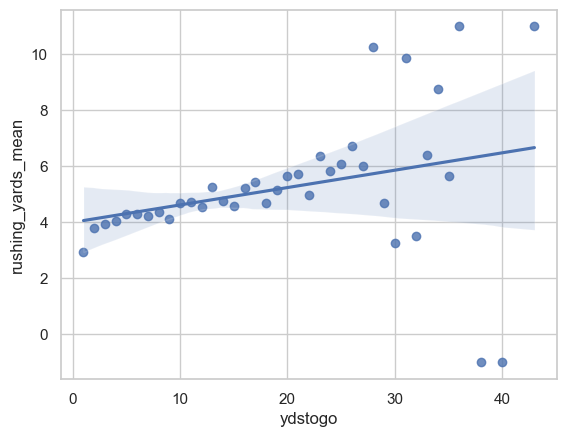

In [5]:
sns.set_theme(style='whitegrid')
sns.regplot(data=play_by_run_avg, 
                x = 'ydstogo',
                y = 'rushing_yards_mean');

In [6]:
corr = 'rushing_yards ~ 1 + ydstogo'

yds_to_go_corr = smf.ols(formula=corr, data = play_by_run)

model_fit = yds_to_go_corr.fit()

intercept = model_fit.params[0]
slope = model_fit.params[1]
r_squared = model_fit.rsquared

print(f'Results: \n\n'+
      f'Our model starts with a {intercept:.2f} yard avg, and increases {slope:.2f} for double (2x) the yards to go\n\n'+
      f'Our R-squared value: {r_squared:.2f} tells us how correlated this effect is.\n\n'
      f'1.0 is perfectly correlated and 0.0 means no corrlation exists.')

Results: 

Our model starts with a 3.28 yard avg, and increases 0.14 for double (2x) the yards to go

Our R-squared value: 0.01 tells us how correlated this effect is.

1.0 is perfectly correlated and 0.0 means no corrlation exists.


In [7]:
play_by_run['rushyds_o_exp'] = model_fit.resid

In [8]:

yds_o_exp = (play_by_run.groupby(['season', 'rusher_id', 'rusher'])
                         .agg({'rushyds_o_exp': ['count', 'sum', 'mean'],
                               'rushing_yards': 'mean'}))

yds_o_exp.columns = yds_o_exp.columns.to_flat_index().str.join('_')

#for readability
yds_o_exp.reset_index(inplace=True)
yds_o_exp.drop(columns = ['rusher_id'], inplace=True)

yds_o_exp.rename(columns={
                    "rushyds_o_exp_count": "count",
                    "rushyds_o_exp_sum": "o_exp",
                    "rushyds_o_exp_mean": "o_x_avg",
                    "rushing_yards_mean": "avg_ypp"}, inplace=True)

print(yds_o_exp.query('count > 50').head())

    season      rusher  count       o_exp   o_x_avg   avg_ypp
8     2018      F.Gore    156   20.732492  0.132901  4.628205
11    2018  A.Peterson    251  -77.764581 -0.309819  4.151394
13    2018     M.Lynch     90  -13.962504 -0.155139  4.177778
28    2018     L.McCoy    161 -205.838324 -1.278499  3.192547
30    2018    L.Blount    154 -257.877129 -1.674527  2.714286


In [9]:
yds_o_exp.query('rusher == "D.Henry"')

,season,rusher,count,o_exp,o_x_avg,avg_ypp
201,2018,D.Henry,215,110.725658,0.515003,4.925581
498,2019,D.Henry,386,293.166273,0.759498,5.145078
795,2020,D.Henry,395,334.432977,0.846666,5.232912
1150,2021,D.Henry,239,-46.221471,-0.193395,4.179916
1496,2022,D.Henry,349,-16.099391,-0.046130,4.406877


In [10]:

list_of_top_five = ["A.Ekeler", "C.McCafferey", "S.Barkley", "T.Pollard", "J.Taylor"]
                    
for rb in list_of_top_five:
    temp_df = yds_o_exp.query(f'rusher == "{rb}"')
    display(temp_df)

,season,rusher,count,o_exp,o_x_avg,avg_ypp
257,2018,A.Ekeler,117,65.921204,0.563429,4.982906
547,2019,A.Ekeler,132,-14.699325,-0.111359,4.219697
848,2020,A.Ekeler,116,12.649866,0.109051,4.568965
1193,2021,A.Ekeler,206,22.932419,0.111322,4.422330
1530,2022,A.Ekeler,217,6.226538,0.028694,4.377880


,season,rusher,count,o_exp,o_x_avg,avg_ypp


,season,rusher,count,o_exp,o_x_avg,avg_ypp
338,2018,S.Barkley,261,144.497708,0.553631,5.007663
620,2019,S.Barkley,217,52.538539,0.242113,4.622120
921,2020,S.Barkley,19,-50.927822,-2.680412,1.789474
1264,2021,S.Barkley,162,-131.071148,-0.809081,3.660494
1595,2022,S.Barkley,313,52.399173,0.167409,4.555911


,season,rusher,count,o_exp,o_x_avg,avg_ypp
647,2019,T.Pollard,86,74.188876,0.862661,5.290698
955,2020,T.Pollard,101,-1.796550,-0.017788,4.306931
1289,2021,T.Pollard,134,141.369887,1.054999,5.470149
1622,2022,T.Pollard,214,154.724525,0.723012,5.168224


,season,rusher,count,o_exp,o_x_avg,avg_ypp
1006,2020,J.Taylor,23,6.093534,0.264936,4.782609
1015,2020,J.Taylor,253,157.669354,0.623199,4.928854
1339,2021,J.Taylor,19,-46.699415,-2.457864,1.947368
1344,2021,J.Taylor,332,389.187098,1.172250,5.454819
1659,2022,J.Taylor,10,-35.785058,-3.578506,0.900000
1662,2022,J.Taylor,192,30.417591,0.158425,4.484375
